# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Caspone Project Indroduction

Starbucks Capstone Challenge:  This project will reach customer via a smartphone application from Starbucks. Based on artifical dataset, we will perform analysis and send offers to specific users who has the highest chance to use it.

Initially we will explore the datasest and collect metrics like information for income, age, provided personal data and more. Then based on the current offer will be created a prediction model per user. The model will provide us witha analysis for:

- Which offer will be successful and profitable?
- How factors like gender/income/average purchase/offer completion time  reflect on the prediction?
- Structure users per user groups and what promotions to sent them via Starbucks app.

## Metrics

Clustering is widely used technique in Data Science. We can group users using Agglomerative method as it offer bottom to top approach or start with small groups and keep adding additional users until we assign all.


References used: 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

## Review datasets

### Portfolio dataset contains information about each offer and its type

In [2]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
# check how many are the null values
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [4]:
# Lets check for the number of the unique offers
portfolio.id.nunique()

10

In [5]:
# Lets count offers by type
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [6]:
portfolio.columns

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'id'], dtype='object')

Analysis on portfolio.json
- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required dollars to spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings) - Nested list

**There are 10 Unique offers and they are distributed:**
- BOGO - 4 offers
- discount - 4 offers
- informational - 2 offers

**There are no Null values into "portfolio" dataset. 

### Profile dataset contains information about each member and its age, income, gender

In [7]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [8]:
# check how many are the null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [9]:
# Calculate how much percent of the values are missing
profile.isnull().sum() * 100 / profile.shape[0]

gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

In [10]:
# filter all rows where gender is Null.
df_gender = profile[profile['gender'].isnull()]

# From the below we can see if gender is not defined and income is not defined
df_gender.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [11]:
# Perform Value counts on the Age so we can use it for the graph
value_counts = profile['age'].value_counts().reset_index()

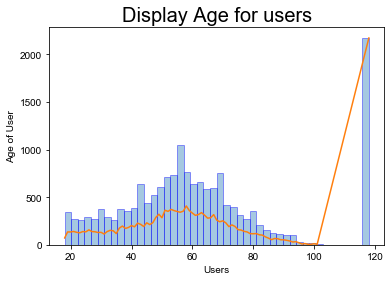

In [12]:
# Now let's check the Age distribution for people 

# Perform Value counts on the Age so we can use it for the graph
value_counts = profile['age'].value_counts().reset_index()

fig= plt.subplots(figsize=(6,4))
sns.set(style="whitegrid")
sns.distplot(profile['age'], kde = False, hist_kws={'edgecolor':'blue'})
sns.lineplot(x=value_counts['index'], y = value_counts['age'],
             data=profile)
plt.title('Display Age for users',size = 20)
plt.xlabel('Users', size =10)
plt.ylabel('Age of User', size =10)

plt.show()

**As users on 118 is unrealistic we need to check if we can drop or modify these users** 

In [13]:
#Calculate how much percent of the users are with age 118
profile[['age', 'gender', 'income']][profile["age"]==118].shape[0]/profile.shape[0]

0.12794117647058822

**These are around 13% but the income, age and gender are also missing as data. So we might consider to drop these rows are they are not providing correct inputs.**

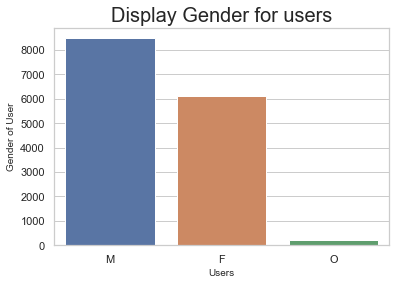

In [14]:
# Now let's check the Gender distribution for people 

# Perform Value counts on the Age so we can use it for the graph
value_counts = profile['gender'].value_counts().reset_index()

fig= plt.subplots(figsize=(6,4))
sns.set(style="whitegrid")
sns.barplot(x=value_counts['index'], y = value_counts['gender'],
             data=profile)
plt.title('Display Gender for users',size = 20)
plt.xlabel('Users', size =10)
plt.ylabel('Gender of User', size =10)

plt.show()

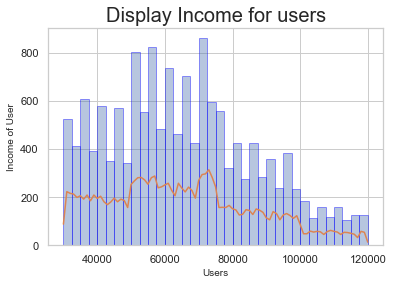

In [15]:
# Now let's check the Income distribution for people 

# Perform Value counts on the Age so we can use it for the graph
value_counts = profile['income'].value_counts().reset_index()

fig= plt.subplots(figsize=(6,4))
sns.set(style="whitegrid")
sns.distplot(profile['income'].dropna(), kde = False, hist_kws={'edgecolor':'blue'})
sns.lineplot(x=value_counts['index'], y = value_counts['income'],
             data=profile)
plt.title('Display Income for users',size = 20)
plt.xlabel('Users', size =10)
plt.ylabel('Income of User', size =10)

plt.show()

**Analysis on profile.json**
- gender (string) - Values M for Male, F for Female and None for Null
- age (int) - contains the age of the customer but there are values of 118 which is unrealiasic high
- id (str) - member ID
- become_member_on (string) - contains date when the member has joined but it need to changed as format
- income (int) - contains data for every person salary but there are Null Values

**If there is Null value into "profile" dataset for 'gender'  so the'income' value is Null as well**

**Users with age of 118 might be dropped as a lot of data is missing in these rows***

### Transcript dataset contains information offers given to each person

In [16]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [17]:
# check how many are the null values
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

**There are no Null values**

In [18]:
transcript['event'].value_counts().reset_index()

,index,event
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


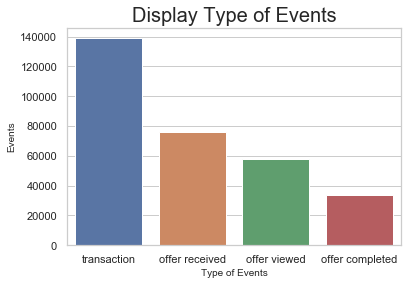

In [19]:
value_counts = transcript['event'].value_counts().reset_index()

fig= plt.subplots(figsize=(6,4))
sns.set(style="whitegrid")
sns.barplot(x=value_counts['index'], y = value_counts['event'],
             data=transcript)
plt.title('Display Type of Events',size = 20)
plt.xlabel('Type of Events', size =10)
plt.ylabel('Events', size =10)

plt.show()

**Analysis on transcript.json**
- person (string) - person who has received the offer
- event (string) - confirmation if offer is received
- value (string) - link to offer id which is received
- time (int) - number of times the offer has been received


**There are no Null values into "transcript" dataset.**

**Now we will proceed with DATA Cleaning and preparation**

**Portfolio Data Set**

In [20]:
np.unique(portfolio['channels'])

array([list(['email', 'mobile', 'social']), list(['web', 'email']),
       list(['web', 'email', 'mobile']),
       list(['web', 'email', 'mobile', 'social'])], dtype=object)

In [21]:
# Lets extract all types of Channels and use them as column names
channel_types = list()
for channel in portfolio['channels']:
    for x in channel:
        if x not in channel_types:
            channel_types.append(x)
            
channel_types

['email', 'mobile', 'social', 'web']

In [22]:
# Add the Columns to the dataset
for channel in channel_types:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)
    
portfolio.drop(columns=['channels'], axis=1, inplace=True)
portfolio.head()

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


**Profile Data Set**

In [23]:
# Drop Null Enries
profile.dropna(subset=['income'], inplace=True)
profile.head(10)

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
13,F,61,aa4862eba776480b8bb9c68455b8c2e1,20170911,57000.0
14,M,26,e12aeaf2d47d42479ea1c4ac3d8286c6,20140213,46000.0
15,F,62,31dda685af34476cad5bc968bdb01c53,20160211,71000.0
16,M,49,62cf5e10845442329191fc246e7bcea3,20141113,52000.0
18,M,57,6445de3b47274c759400cd68131d91b4,20171231,42000.0


In [24]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

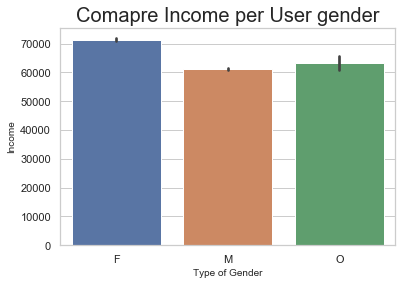

In [25]:
# Compare Income per User gender

fig= plt.subplots(figsize=(6,4))
sns.set(style="whitegrid")
sns.barplot(x=profile['gender'], y = profile['income'],
             data=profile)
plt.title('Comapre Income per User gender',size = 20)
plt.xlabel('Type of Gender', size =10)
plt.ylabel('Income', size =10)

plt.show()

In [26]:
# Convert the Date Format to an actual date in column "Become Member On"
profile["became_member_on"] =  pd.to_datetime(profile["became_member_on"], format='%Y%m%d')
profile.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


**Based on "become_member_on" we can analyze how many subscriptions are there per month and per year.**

**Per Year**

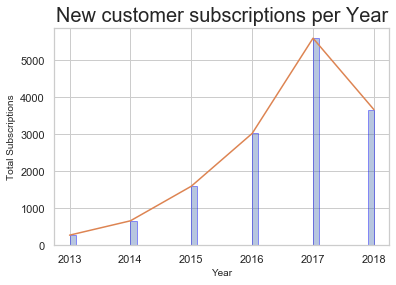

In [27]:
# Perform Value counts on when user has joined so we can use it for the graph
value_counts = profile['became_member_on'].dt.year.value_counts().reset_index()

fig= plt.subplots(figsize=(6,4))
sns.set(style="whitegrid")
sns.distplot(profile['became_member_on'].dt.year, kde = False, hist_kws={'edgecolor':'blue'})
sns.lineplot(x=value_counts['index'], y = value_counts['became_member_on'],
             data=profile)
plt.title('New customer subscriptions per Year',size = 20)
plt.xlabel('Year', size =10)
plt.ylabel('Total Subscriptions', size =10)

plt.show()

**Per Month**

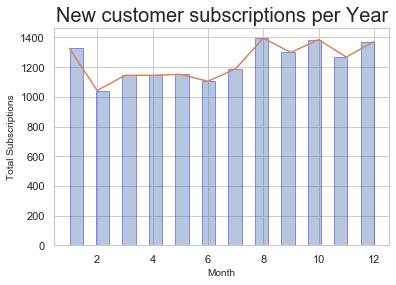

In [28]:
# Perform Value counts on when user has joined so we can use it for the graph
value_counts = profile['became_member_on'].dt.month.value_counts().reset_index()

fig= plt.subplots(figsize=(6,4))
sns.set(style="whitegrid")
sns.distplot(profile['became_member_on'].dt.month, kde = False, hist_kws={'edgecolor':'blue'})
sns.lineplot(x=value_counts['index'], y = value_counts['became_member_on'],
             data=profile)
plt.title('New customer subscriptions per Year',size = 20)
plt.xlabel('Month', size =10)
plt.ylabel('Total Subscriptions', size =10)

plt.show()

**Transcript Data Set**

In [29]:
# First we will splitkey/values form transcript['value'] column 

transcript['key'] = transcript['value'].apply(lambda x: list(x.keys())[0])
transcript['value'] = transcript['value'].apply(lambda x: list(x.values())[0])
transcript['time'] = transcript['time'].apply(lambda x: int(x))

transcript.head()

,person,event,value,time,key
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer id
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer id
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0,offer id
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0,offer id
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0,offer id


In [30]:
# Let see now the data in "key" column
transcript.key.value_counts()

amount      138953
offer id    134002
offer_id     33579
Name: key, dtype: int64

In [31]:
# We can see there is three Values two of which are same but spelled differently
transcript['key'] = transcript['key'].str.replace('offer id','offer_id')
transcript.key.value_counts()

offer_id    167581
amount      138953
Name: key, dtype: int64

In [32]:
# Next we will check the Events
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [33]:
# We can see 4 types of events where the completed ones are the one which has driven the business forward
# Let classify further the completed

offers_count = transcript['event'].value_counts()
offers_percent = transcript['event'].value_counts(normalize = True).mul(100)
pd.concat([offers_count,offers_percent], axis=1, keys=['counts', '%'])

,counts,%
transaction,138953,45.330371
offer received,76277,24.883700
offer viewed,57725,18.831516
offer completed,33579,10.954413


**Completed offers are around 11%**

In [34]:
# User data from 'transcript' and 'portfolio' to Add the offer type. We will merge on Value
portfolio.rename(columns={'id':'value'},inplace=True)

offers = transcript.merge(portfolio[['offer_type', 'value']].copy(),how='left',on='value')

percent = offers.groupby(['event','offer_type'])['event'].count()
percent / percent.groupby(level=0).sum()

event            offer_type   
offer completed  bogo             0.466631
                 discount         0.533369
offer received   bogo             0.399845
                 discount         0.400422
                 informational    0.199733
offer viewed     bogo             0.440866
                 discount         0.371503
                 informational    0.187631
Name: event, dtype: float64

**Now we can see that completed offers are two subtypes and how much percent of each we have:**

- bogo             46.66 %
- discount         53.34 %

In [35]:
# create Completed_Offer column 
offer_completion = pd.merge(
                        transcript[transcript['event'] == 'offer received']
                        , transcript[transcript['event'] == 'offer completed']
                        , left_on = ['person','value']
                        , right_on = ['person','value']
                        , how = 'left')

offer_completion['Completed_Offer'] = offer_completion['event_y'].apply(lambda x: 0 if pd.isnull(x) == True else 1)
offer_completion.head()

,person,event_x,value,time_x,key_x,event_y,time_y,key_y,Completed_Offer
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer_id,offer completed,132.0,offer_id,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer_id,NaN,NaN,NaN,0
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0,offer_id,NaN,NaN,NaN,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0,offer_id,NaN,NaN,NaN,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0,offer_id,NaN,NaN,NaN,0


In [36]:
completed_offer_df = pd.merge(offer_completion, portfolio, how = 'inner', left_on = 'value', right_on = 'value')[[
    'person','time_x','value','Completed_Offer', 'duration','offer_type','reward','difficulty', 'email', 
    'mobile', 'social', 'web']]

In [37]:
completed_offer_df['reward_value'] = completed_offer_df['reward'] - completed_offer_df['difficulty']

# Now we can create a clustering

In [38]:
profile.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


**Create a new data set with all customer data in one place to perform Clustering:**

    'person'
    'gender'
    'age'
    'income'
    'became_member_on'
    'avg_transactions_amount'
    'total_transactions_amount'
    'total_transactions'
    'avg_days_between_purchase'
    'bogo_all_offers_received'
    'bogo_all_offers_completed'
    'bogo_average_reward
    'discount_all_offers_received'
    'discount_all_offers_completed'
    'discount_average_reward'
    'informational_offers'



In [39]:
sbx_customers = pd.DataFrame(columns=['person', 'gender', 'age', 'income', 'became_member_on', 'avg_transactions_amount',
                 'total_transactions_amount', 'total_transactions', 'avg_days_between_purchase',
                 'bogo_all_offers_received', 'bogo_all_offers_completed', 
                 'bogo_average_reward', 'discount_all_offers_received', 'discount_all_offers_completed',
                 'discount_average_reward', 'informational_offers'
                ])
sbx_customers

,person,gender,age,income,became_member_on,avg_transactions_amount,total_transactions_amount,total_transactions,avg_days_between_purchase,bogo_all_offers_received,bogo_all_offers_completed,bogo_average_reward,discount_all_offers_received,discount_all_offers_completed,discount_average_reward,informational_offers


In [40]:
user_transactions = transcript[transcript['key'] == 'amount']

pd.options.mode.chained_assignment = None 
user_transactions['value'] = user_transactions['value'].astype(float)

user_transactions.head()

,person,event,value,time,key
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0.83,0,amount
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,34.56,0,amount
12659,54890f68699049c2a04d415abc25e717,transaction,13.23,0,amount
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,19.51,0,amount
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,18.97,0,amount


In [41]:
# create Completed_Offer DF
offer_completion = pd.merge(
                         offers[offers['event'] == 'offer received']
                         , offers[offers['event'] == 'offer completed']
                         , left_on = ['person','value']
                         , right_on = ['person','value']
                         , how = 'left')

offer_completion['Completed_Offer'] = offer_completion['event_y'].apply(lambda x: 0 if pd.isnull(x) == True else 1)
offer_completion.head()

,person,event_x,value,time_x,key_x,offer_type_x,event_y,time_y,key_y,offer_type_y,Completed_Offer
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer_id,bogo,offer completed,132.0,offer_id,bogo,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer_id,discount,NaN,NaN,NaN,NaN,0
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0,offer_id,discount,NaN,NaN,NaN,NaN,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0,offer_id,discount,NaN,NaN,NaN,NaN,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0,offer_id,bogo,NaN,NaN,NaN,NaN,0


In [42]:
for person in np.unique(profile['id']):
    
    # Customer details 
    personal_data = profile[profile['id'] == person][['id', 'gender', 'age', 'income', 'became_member_on']]

    # Customer transactions 
    personal_transactions = user_transactions[user_transactions['person'] == person].reset_index()
    if len(personal_transactions) > 0:
        personal_transactions['last_purchase_in_days'] = personal_transactions.time.diff()
        personal_transactions.iloc[0, -1] = personal_transactions.loc[0, 'time']
        personal_grouped_trs = personal_transactions.groupby('person', as_index = False).agg(
            {
                'time': ['count']
                , 'value': ['mean', 'sum']
                , 'last_purchase_in_days': ['mean']  
            })
        personal_grouped_trs.columns = ['person', 'total_transactions', 'avg_transaction_amount',
                                        'total_transactions_amount','avg_days_between_purchase']
        
    else:
        nan_array = [person, np.nan, np.nan, np.nan, np.nan]
        personal_grouped_trs = pd.DataFrame([nan_array]
                                         , columns = ['person', 'total_transactions', 'avg_transaction_amount',
                                                      'total_transactions_amount','avg_days_between_purchase'
                                                     ])
        
    personal_df = pd.merge(personal_data, personal_grouped_trs, how = 'inner', left_on = 'id', right_on = 'person')
    personal_df.drop('id', axis = 1, inplace = True)
    
    for offer in ['discount','bogo']:
        globals()[offer + '_df'] =  completed_offer_df[(completed_offer_df['person'] == person)
                       & (completed_offer_df['offer_type'] == offer)
                       ].groupby('person', as_index = False).agg({
                                                        'Completed_Offer':['count','sum'],
                                                        'reward': ['mean']
                                                        })
        
        globals()[offer + '_df'].columns = globals()[offer + '_df'].columns.droplevel(1)
        globals()[offer + '_df'].columns = ['person', offer + '_all_offers_received', offer + '_all_offers_completed',
                                            offer + '_average_reward']
        
        if len(globals()[offer + '_df']) == 0:
            nan_array = [person,np.nan,np.nan,np.nan]
            globals()[offer + '_df'] = globals()[offer + '_df'].append(
                dict(zip(globals()[offer + '_df'].columns, nan_array)), ignore_index=True)
    
    bogo_discounts = pd.merge(bogo_df,discount_df)
    bogo_discounts['informational_offers'] = len(completed_offer_df[(completed_offer_df['person'] == person)
                                                               & (completed_offer_df['offer_type'] == 'informational')])
    
    sbx_customers = sbx_customers.append(pd.merge(personal_df, bogo_discounts),sort=True)    

sbx_customers.head()

,age,avg_days_between_purchase,avg_transaction_amount,avg_transactions_amount,became_member_on,bogo_all_offers_completed,bogo_all_offers_received,bogo_average_reward,discount_all_offers_completed,discount_all_offers_received,discount_average_reward,gender,income,informational_offers,person,total_transactions,total_transactions_amount
0,33,87.000000,15.950000,NaN,2017-04-21,1,1,5,2,2,2,M,72000.0,2,0009655768c64bdeb2e877511632db8f,8,127.60
0,40,130.800000,15.892000,NaN,2018-01-09,1,1,5,2,2,4,O,57000.0,2,0011e0d4e6b944f998e987f904e8c1e5,5,79.46
0,59,88.500000,24.607500,NaN,2016-03-04,1,2,10,4,4,2,F,90000.0,1,0020c2b971eb4e9188eac86d93036a77,8,196.86
0,24,56.000000,12.837500,NaN,2016-11-11,2,2,5,1,1,3,F,60000.0,1,0020ccbbb6d84e358d3414a3ff76cffd,12,154.05
0,26,38.666667,2.685556,NaN,2017-06-21,NaN,NaN,NaN,5,5,2.6,F,73000.0,2,003d66b6608740288d6cc97a6903f4f0,18,48.34


In [43]:
# Create a csv file for backup as records are a lot and takes time to calculate
sbx_customers.to_csv('sbx_customers.csv')

In [44]:
# Read the records as we need to experiment and analyze the set
sbx_customers = pd.read_csv('sbx_customers.csv')
sbx_customers.head()

,Unnamed: 0,age,avg_days_between_purchase,avg_transaction_amount,avg_transactions_amount,became_member_on,bogo_all_offers_completed,bogo_all_offers_received,bogo_average_reward,discount_all_offers_completed,discount_all_offers_received,discount_average_reward,gender,income,informational_offers,person,total_transactions,total_transactions_amount
0,0,33,87.000000,15.950000,NaN,2017-04-21,1.0,1.0,5.0,2.0,2.0,2.0,M,72000.0,2,0009655768c64bdeb2e877511632db8f,8.0,127.60
1,0,40,130.800000,15.892000,NaN,2018-01-09,1.0,1.0,5.0,2.0,2.0,4.0,O,57000.0,2,0011e0d4e6b944f998e987f904e8c1e5,5.0,79.46
2,0,59,88.500000,24.607500,NaN,2016-03-04,1.0,2.0,10.0,4.0,4.0,2.0,F,90000.0,1,0020c2b971eb4e9188eac86d93036a77,8.0,196.86
3,0,24,56.000000,12.837500,NaN,2016-11-11,2.0,2.0,5.0,1.0,1.0,3.0,F,60000.0,1,0020ccbbb6d84e358d3414a3ff76cffd,12.0,154.05
4,0,26,38.666667,2.685556,NaN,2017-06-21,NaN,NaN,NaN,5.0,5.0,2.6,F,73000.0,2,003d66b6608740288d6cc97a6903f4f0,18.0,48.34


In [45]:
# Clean Up age 118 and fill all Null values with 0s 
sbx_customers.age = sbx_customers.age.replace(118, np.nan)

# fill with 0
sbx_customers = sbx_customers.fillna(0)

In [46]:
# We also need to remove objects and use float and int type for the models
sbx_customers_models = sbx_customers[['age',
 'avg_days_between_purchase',
 'avg_transaction_amount',
 'avg_transactions_amount',
 'bogo_all_offers_completed',
 'bogo_all_offers_received',
 'bogo_average_reward',
 'bogo_all_offers_completed',
 'discount_all_offers_completed',
 'discount_all_offers_received',
 'discount_average_reward',
 'discount_all_offers_completed',
 'gender',
 'income',
 'informational_offers',
 'total_transactions_amount',
 'total_transactions',
 'total_transactions_amount']]

In [47]:
# Create  dummies for Gender
sbx_customers_models = pd.get_dummies(data=sbx_customers_models, columns=['gender'])
sbx_customers_models.head()

,age,avg_days_between_purchase,avg_transaction_amount,avg_transactions_amount,bogo_all_offers_completed,bogo_all_offers_received,bogo_average_reward,bogo_all_offers_completed,discount_all_offers_completed,discount_all_offers_received,discount_average_reward,discount_all_offers_completed,income,informational_offers,total_transactions_amount,total_transactions,total_transactions_amount,gender_F,gender_M,gender_O
0,33,87.000000,15.950000,0.0,1.0,1.0,5.0,1.0,2.0,2.0,2.0,2.0,72000.0,2,127.60,8.0,127.60,0,1,0
1,40,130.800000,15.892000,0.0,1.0,1.0,5.0,1.0,2.0,2.0,4.0,2.0,57000.0,2,79.46,5.0,79.46,0,0,1
2,59,88.500000,24.607500,0.0,1.0,2.0,10.0,1.0,4.0,4.0,2.0,4.0,90000.0,1,196.86,8.0,196.86,1,0,0
3,24,56.000000,12.837500,0.0,2.0,2.0,5.0,2.0,1.0,1.0,3.0,1.0,60000.0,1,154.05,12.0,154.05,1,0,0
4,26,38.666667,2.685556,0.0,0.0,0.0,0.0,0.0,5.0,5.0,2.6,5.0,73000.0,2,48.34,18.0,48.34,1,0,0


In [48]:
# Check for Null Values
sbx_customers_models.isnull().sum()

age                              0
avg_days_between_purchase        0
avg_transaction_amount           0
avg_transactions_amount          0
bogo_all_offers_completed        0
bogo_all_offers_received         0
bogo_average_reward              0
bogo_all_offers_completed        0
discount_all_offers_completed    0
discount_all_offers_received     0
discount_average_reward          0
discount_all_offers_completed    0
income                           0
informational_offers             0
total_transactions_amount        0
total_transactions               0
total_transactions_amount        0
gender_F                         0
gender_M                         0
gender_O                         0
dtype: int64

## Implementation

Let start now to apply k-mean clustering on sbx_customers DF. Then we will use the average within-cluster distances from each user to their assigned cluster to decide how many clusters do we need.


There are four combination that we can make between BOGO and Discounts:

- used both offers - BOGO and Discount
- preferred BOGO over Discount
- preferred Discount over BOGO
- did not use the offers


In [49]:
# Check before if all columns are in correct type
sbx_customers_models.dtypes

age                                int64
avg_days_between_purchase        float64
avg_transaction_amount           float64
avg_transactions_amount          float64
bogo_all_offers_completed        float64
bogo_all_offers_received         float64
bogo_average_reward              float64
bogo_all_offers_completed        float64
discount_all_offers_completed    float64
discount_all_offers_received     float64
discount_average_reward          float64
discount_all_offers_completed    float64
income                           float64
informational_offers               int64
total_transactions_amount        float64
total_transactions               float64
total_transactions_amount        float64
gender_F                           uint8
gender_M                           uint8
gender_O                           uint8
dtype: object

In [50]:
# run k-means clustering on the data and...
# compute the average within-cluster distances.

def get_kmeans_score(dataset, center):
    '''
    returns the k-means score regarding SSE for points to centers
    INPUT:
        dataset - the dataset you want to fit kmeans to
        center - the number of clusters you want (the k value)
    OUTPUT:
        score - the SSE score for the k-means model fit to the data
    '''
    #instantiate kmeans
    k_means = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = k_means.fit(dataset)

    # Obtain a score related to the model fit
    score = np.abs(model.score(dataset))

    return score

scores = list()
centers = list(range(1,11))

for center_id in centers:
    scores.append(get_kmeans_score(sbx_customers_models, center_id))

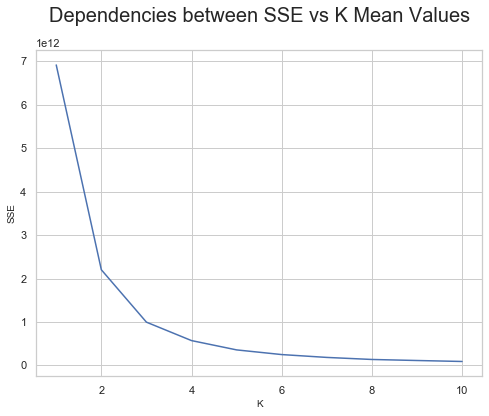

In [51]:
# Investigate the change in within-cluster distance across number of clusters.
fig= plt.subplots(figsize=(8,6))
sns.set(style="whitegrid")
sns.lineplot(x=centers, y = scores, data=sbx_customers_models)
plt.title('Dependencies between SSE vs K Mean Values\n',size = 20)
plt.xlabel('K', size =10)
plt.ylabel('SSE', size =10)

plt.show()

The graph shows that 4 clusters is a number of clusters and we should use Agglomerative Clustering

In [52]:
# Create Agglomerative Clustering object
AggCluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')

# Train model
sbx_customers['cluster_num'] = AggCluster.fit_predict(sbx_customers_models)

In [53]:

#sbx_customers.drop('Unnamed: 0', axis=1, inplace=True)
sbx_customers.head()

,Unnamed: 0,age,avg_days_between_purchase,avg_transaction_amount,avg_transactions_amount,became_member_on,bogo_all_offers_completed,bogo_all_offers_received,bogo_average_reward,discount_all_offers_completed,discount_all_offers_received,discount_average_reward,gender,income,informational_offers,person,total_transactions,total_transactions_amount,cluster_num
0,0,33,87.000000,15.950000,0.0,2017-04-21,1.0,1.0,5.0,2.0,2.0,2.0,M,72000.0,2,0009655768c64bdeb2e877511632db8f,8.0,127.60,0
1,0,40,130.800000,15.892000,0.0,2018-01-09,1.0,1.0,5.0,2.0,2.0,4.0,O,57000.0,2,0011e0d4e6b944f998e987f904e8c1e5,5.0,79.46,0
2,0,59,88.500000,24.607500,0.0,2016-03-04,1.0,2.0,10.0,4.0,4.0,2.0,F,90000.0,1,0020c2b971eb4e9188eac86d93036a77,8.0,196.86,3
3,0,24,56.000000,12.837500,0.0,2016-11-11,2.0,2.0,5.0,1.0,1.0,3.0,F,60000.0,1,0020ccbbb6d84e358d3414a3ff76cffd,12.0,154.05,0
4,0,26,38.666667,2.685556,0.0,2017-06-21,0.0,0.0,0.0,5.0,5.0,2.6,F,73000.0,2,003d66b6608740288d6cc97a6903f4f0,18.0,48.34,0


In [54]:
# Calculate which cluster has the most users
sbx_customers['cluster_num'].value_counts(normalize = True).mul(100)

0    47.244519
2    25.504216
1    14.084317
3    13.166948
Name: cluster_num, dtype: float64

Cluster 2 has the highest number customers while 0,1 has very close to each other customers

In [55]:
sbx_customers.head()

,Unnamed: 0,age,avg_days_between_purchase,avg_transaction_amount,avg_transactions_amount,became_member_on,bogo_all_offers_completed,bogo_all_offers_received,bogo_average_reward,discount_all_offers_completed,discount_all_offers_received,discount_average_reward,gender,income,informational_offers,person,total_transactions,total_transactions_amount,cluster_num
0,0,33,87.000000,15.950000,0.0,2017-04-21,1.0,1.0,5.0,2.0,2.0,2.0,M,72000.0,2,0009655768c64bdeb2e877511632db8f,8.0,127.60,0
1,0,40,130.800000,15.892000,0.0,2018-01-09,1.0,1.0,5.0,2.0,2.0,4.0,O,57000.0,2,0011e0d4e6b944f998e987f904e8c1e5,5.0,79.46,0
2,0,59,88.500000,24.607500,0.0,2016-03-04,1.0,2.0,10.0,4.0,4.0,2.0,F,90000.0,1,0020c2b971eb4e9188eac86d93036a77,8.0,196.86,3
3,0,24,56.000000,12.837500,0.0,2016-11-11,2.0,2.0,5.0,1.0,1.0,3.0,F,60000.0,1,0020ccbbb6d84e358d3414a3ff76cffd,12.0,154.05,0
4,0,26,38.666667,2.685556,0.0,2017-06-21,0.0,0.0,0.0,5.0,5.0,2.6,F,73000.0,2,003d66b6608740288d6cc97a6903f4f0,18.0,48.34,0


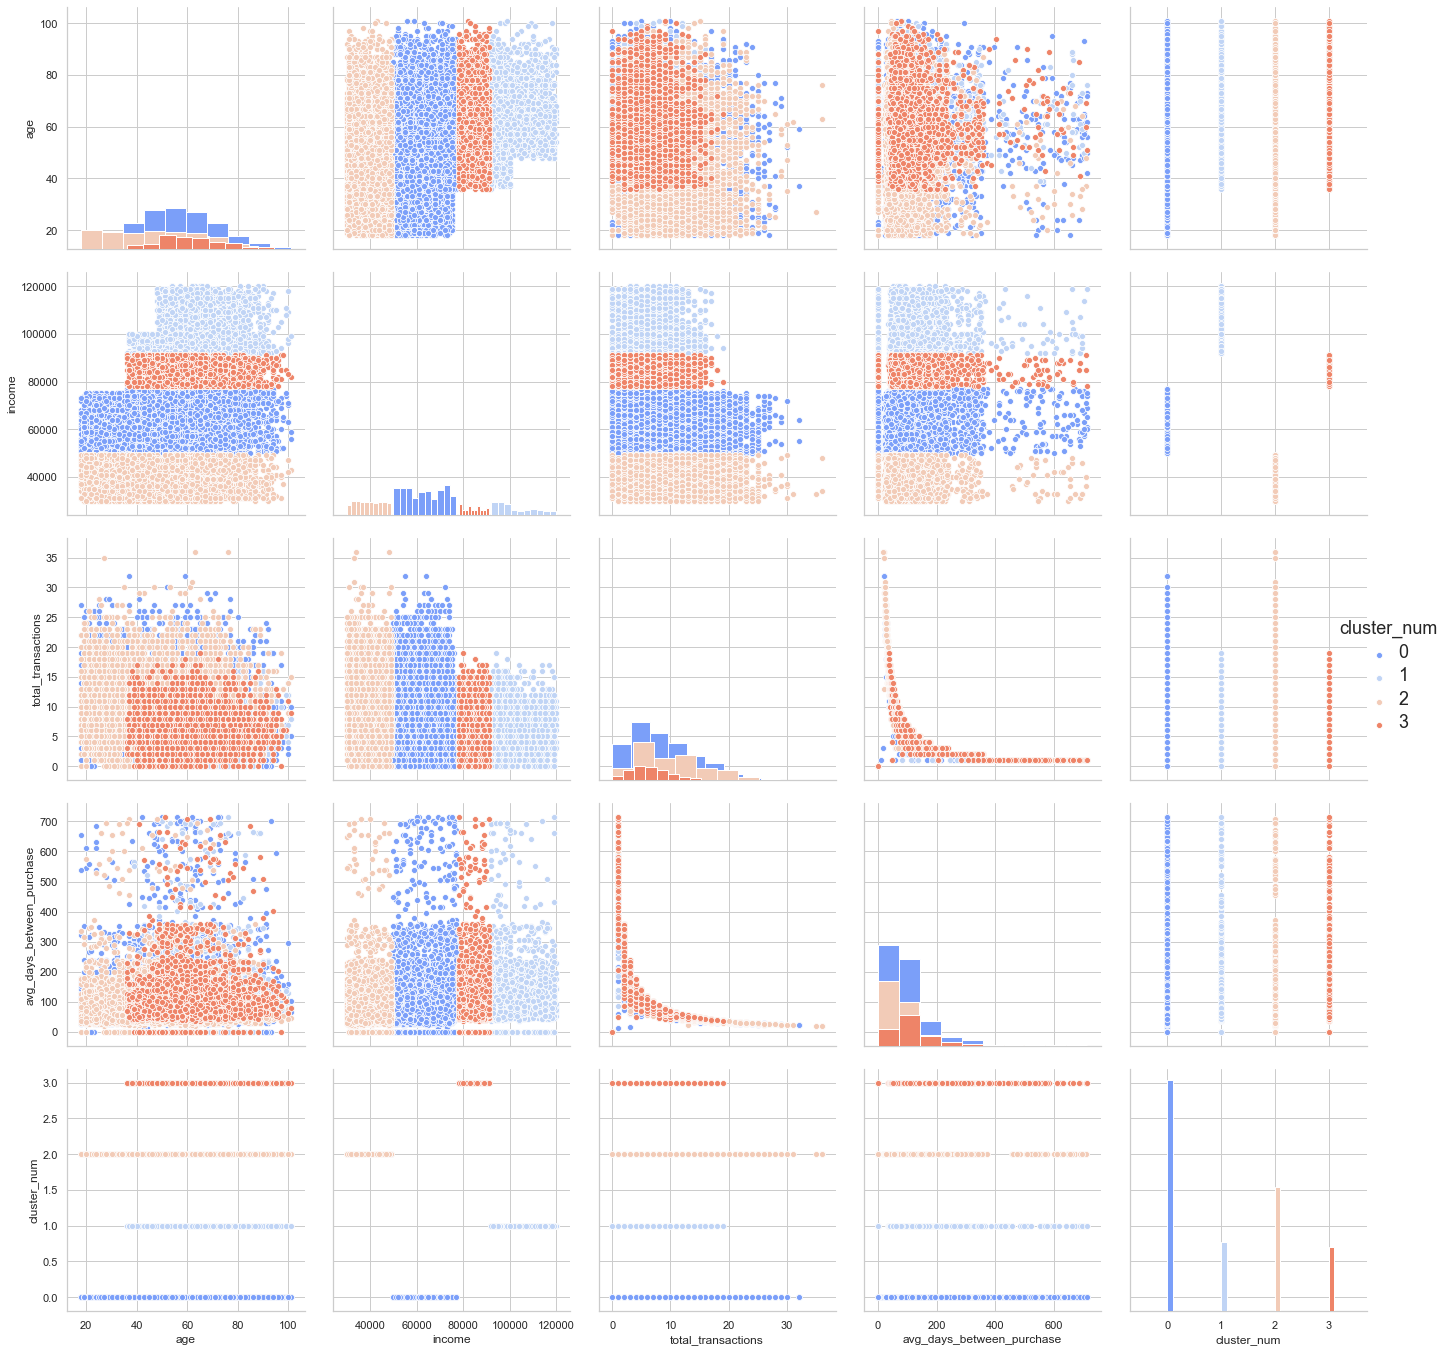

In [56]:
# Lets explore the dependencies between below Columns and color based on Custer ID 
col_list = ['age','income', 'total_transactions', 'avg_days_between_purchase' ,'cluster_num']
g = sns.pairplot(sbx_customers[col_list],hue='cluster_num',diag_kind='hist',palette='coolwarm', height=3.8)
plt.setp(g._legend.get_texts(), fontsize=18)
plt.setp(g._legend.get_title(), fontsize=18)

plt.show()

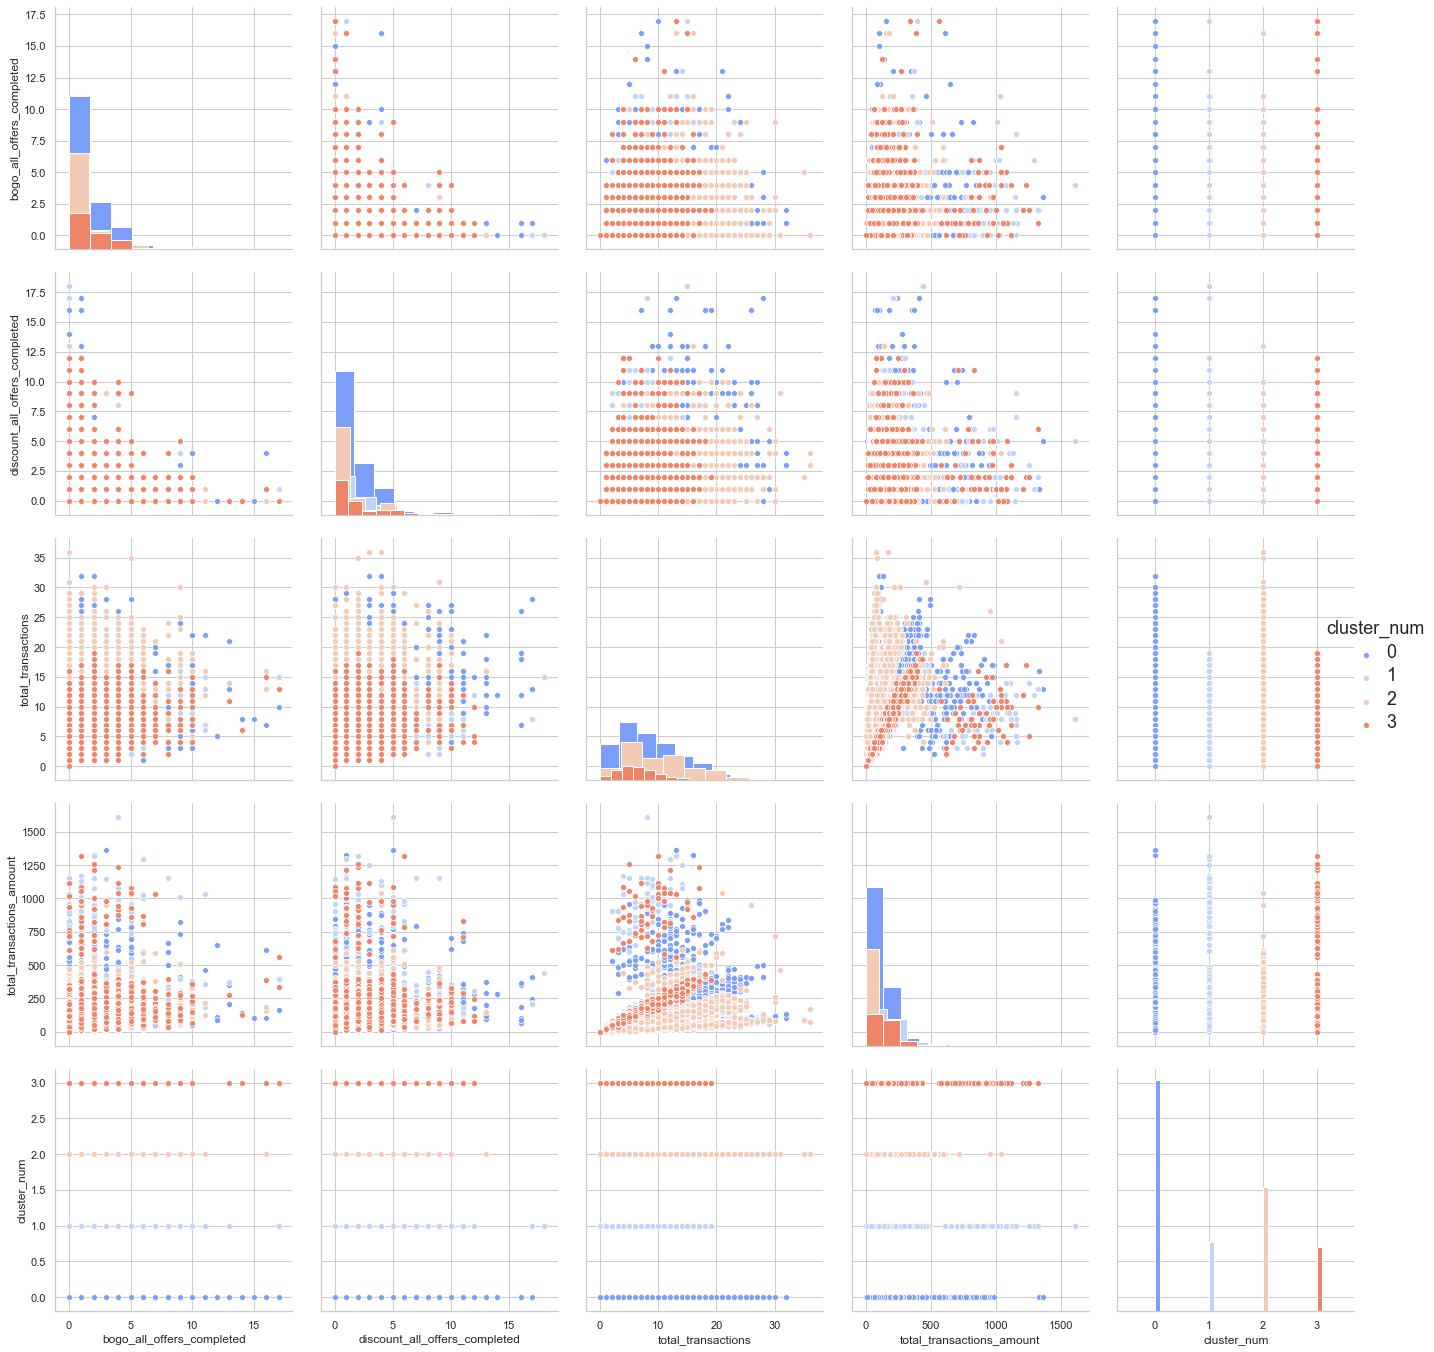

In [57]:
# Lets explore the dependencies between below Columns and color based on Custer ID 
col_list = ['bogo_all_offers_completed', 'discount_all_offers_completed', 'total_transactions',
            'total_transactions_amount', 'cluster_num']
g = sns.pairplot(sbx_customers[col_list],hue='cluster_num',diag_kind='hist',palette='coolwarm', height=3.8)
plt.setp(g._legend.get_texts(), fontsize=18)
plt.setp(g._legend.get_title(), fontsize=18)

plt.show()

<Figure size 1152x864 with 0 Axes>

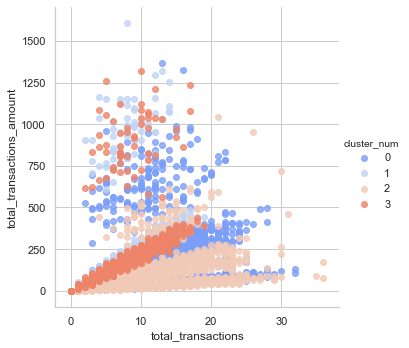

In [58]:
# Lets explore the dependencies between below Columns and color based on Custer ID 
plt.figure(figsize = (16,12))
sns.lmplot(x='total_transactions', y='total_transactions_amount', palette='coolwarm', hue='cluster_num'
           , data=sbx_customers, fit_reg=False);

<Figure size 1152x864 with 0 Axes>

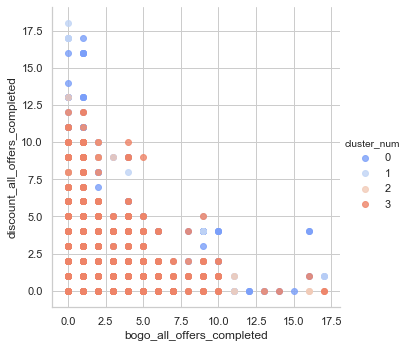

In [59]:
plt.figure(figsize = (16,12))
sns.lmplot(x='bogo_all_offers_completed', y='discount_all_offers_completed', palette='coolwarm', hue='cluster_num'
           , data=sbx_customers, fit_reg=False);

<Figure size 1152x864 with 0 Axes>

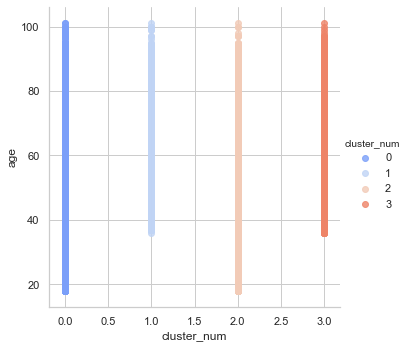

In [60]:
plt.figure(figsize = (16,12))
sns.lmplot(x='cluster_num', y='age', palette='coolwarm', hue='cluster_num'
           , data=sbx_customers, fit_reg=False);

In [61]:
sbx_customers.columns

Index(['Unnamed: 0', 'age', 'avg_days_between_purchase',
       'avg_transaction_amount', 'avg_transactions_amount', 'became_member_on',
       'bogo_all_offers_completed', 'bogo_all_offers_received',
       'bogo_average_reward', 'discount_all_offers_completed',
       'discount_all_offers_received', 'discount_average_reward', 'gender',
       'income', 'informational_offers', 'person', 'total_transactions',
       'total_transactions_amount', 'cluster_num'],
      dtype='object')

In [62]:
# Lets explore the distribution of offers per cluster

completed_offer_per_cluster = pd.merge(completed_offer_df, sbx_customers[['person','cluster_num']]).groupby(
                            ['cluster_num','offer_type','difficulty','reward']
                            , as_index = False ).agg({
                                        'Completed_Offer':['mean', 'sum'],
                                        'reward_value': 'max'
})

completed_offer_per_cluster= completed_offer_per_cluster[completed_offer_per_cluster['offer_type'] != 'informational']
completed_offer_per_cluster.columns.droplevel(1)
completed_offer_per_cluster.columns = ['cluster_num', 'offer_type', 'difficulty', 'reward', 'Completed_Offer_mean',
                                       'Completed_Offer_sum', 'reward_value']

<Figure size 1152x864 with 0 Axes>

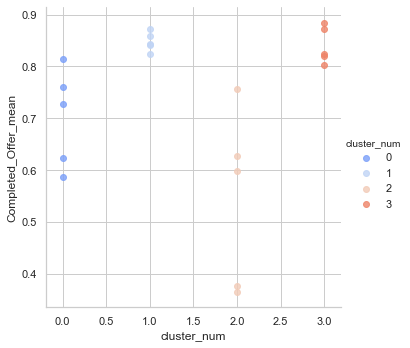

In [64]:
# Lets explore reletaions between Clusters and Completed Offers Mean

plt.figure(figsize = (16,12))
sns.lmplot(x='cluster_num', y='Completed_Offer_mean', palette='coolwarm', hue='cluster_num'
           , data=completed_offer_per_cluster, fit_reg=False);

<Figure size 1152x864 with 0 Axes>

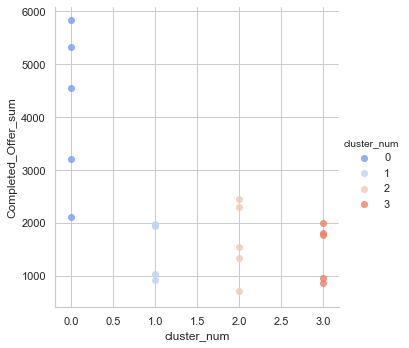

In [66]:
# Lets explore reletaions between Clusters and Completed Offers Sum

plt.figure(figsize = (16,12))
sns.lmplot(x='cluster_num', y='Completed_Offer_sum', palette='coolwarm', hue='cluster_num'
           , data=completed_offer_per_cluster, fit_reg=False);

## Improvement

Final data frame "completed_offer_per_cluster" can be extended to include information when the member joined. Different techniques and predictions can be tried and compare their results. We can also group clusters by mean and sum. But so far we have enough data for users and their clusters. 

## Conclusion
Starbucks Customers gender distribution is 60/40 % males/females where more than 60% of with age between 45-60 years. 
The average income is around 65K per year. Customers who didn't provide income and detailed personal information, also did not respond to offers.

Based on the prediction Models we can see that customers have 
- 1) highest interested in Discount Offers
- 2) next in BOGO offers
- 3) least interested into Informational Offers

Analysis per Cluster
- 0) the second lagest group of customers. These customers are on higher Age but they have reacted very well on discounted offers. These are people with highest income hence they respond better to an offer and will more likely to spend more on Starbucks products where BOGO and Discount offers will be well received.
- 1) the third/fourth group of customers. These customer have average income and has shown interest in BOGO offers. 
- 2) the highest number of customers ~41%. But those customers will probably buy anyway even without offers.
- 3) the third/fourth group of customers. This group has shown the lowest number of transactions and they have lowest income. The chances to get Discounted offer here are better.

